Data:Based 1

In [1]:
import pandas as pd
import numpy as np
import altair as alt

Reading In

In [2]:
pd.options.display.float_format = '{:.2f}'.format
no_division_before = True
no_append_before = True
no_reindex = True

In [3]:
df = pd.read_csv("./Data/prc_ppp_ind.tsv", sep= "\t")

In [4]:
categories = pd.read_excel(sheet_name= "61_Analytical_Categories", io ="./Data/categories.xlsx")

In [5]:
gdp = pd.read_excel(io = "./Data/gdp.xls")

Preprocess GDP To get merged

In [6]:
gdp.rename(columns= {"geo\\time":"country"}, inplace = True)

In [7]:
gdp.loc[gdp.country == "EU28","country"] = "EU27"

In [8]:
gdp.set_index("country",inplace = True)

In [9]:
gdp = gdp.apply(pd.to_numeric, errors='coerce', downcast = "integer")

In [10]:
gdp_normed = gdp/gdp.loc["EU27",:]

In [11]:
gdp_normed.reset_index(inplace = True)

In [12]:
gdp_normed["type"], gdp_normed["item"], gdp_normed["Label"] = ["gdp","gdp","gdp"]

In [13]:
df["type"], df["item"], df["country"] = df.iloc[:,0].str.split(",").str

In [14]:
df.drop(columns="na_item,aggreg,geo\\time", inplace = True)

Merging

In [15]:
df.loc[:,:"1995 "] = df.loc[:,:"1995 "].apply(pd.to_numeric, errors='coerce', downcast = "integer")

In [16]:
nr_columns = pd.to_numeric(df.columns[:-3]).to_list()
nr_columns = [str(col) for col in nr_columns]
other_columns = df.columns[-3:].to_list()

In [17]:
nr_columns.extend(other_columns)

In [18]:
df.columns = nr_columns

In [19]:
gdp.reset_index(inplace = True)

In [20]:
gdp_normed = gdp_normed.round(decimals = 4)

In [21]:
df_full = pd.merge(df, categories, left_on = "item", right_on= "Code", how = "left" )

In [22]:
df_full.drop(columns= "Code", inplace = True)

In [23]:
if no_append_before:
    df_full = df_full.append(gdp_normed, ignore_index= True, sort = True)
    no_append_before = False

Filtering

In [24]:
df_full = df_full.loc[df_full.country != "LU",:]

In [25]:
df_full = df_full.melt(id_vars=["type", "item","country","Label"], var_name = "year")

In [26]:
df_full.year = pd.to_numeric(df_full.year)

df_full = df_full.loc[df_full.year.isin(range(2000,2018)),:]

df_full = df_full.loc[df_full.Label.isin(["Food Overall",
                                          "Meat",
                                          "Bread and cereals",
                                          "Housing, water, electricity, gas and other fuels",
                                          "Restaurants and hotels",
                                          "Alcoholic beverages",
                                          "Households appliances",
                                          "Transport",                                          
                                          "gdp"]), :]

df_full = df_full.loc[df_full.type.isin(["PLI_EU27","gdp"])]

df_full = df_full.loc[np.logical_and(df_full.country.isin(gdp.country.unique()),df_full.country !="EA19") ,:]

In [27]:
if no_division_before:
    df_full.value = df_full.value.where(df_full.type == "gdp",df_full.value/100)
    no_division_before = True 

In [28]:
reindexed_full = df_full.groupby(["item","country", "Label","year"]).first()

In [29]:
reindexed_gdp_normed = reindexed_full.loc["gdp",:].value.droplevel("Label")

In [30]:
purchasing_power = (reindexed_full.value/ reindexed_gdp_normed) ** -1

In [31]:
purchasing_power = purchasing_power.rename("PP")

In [32]:
reindexed_full.index.names

FrozenList(['item', 'country', 'Label', 'year'])

In [33]:
if no_reindex:
    purchasing_power.index = purchasing_power.index.reorder_levels([2,0,3,1])
    no_reindex = False

In [34]:
df_pp = pd.concat([reindexed_full, purchasing_power], axis = 1, ignore_index= False)

In [35]:
df_pp= df_pp.loc[df_pp.type != "gdp",:]
reindexed_gdp_normed = reindexed_gdp_normed.rename("gdp")

In [36]:
index_to_preserve = df_pp.index

In [37]:
df_fin = pd.merge(df_pp, reindexed_gdp_normed, on = ["country","year"],how = "left")

In [38]:
df_fin.index = df_pp.index

In [39]:
df_fin = df_fin.reset_index()
df_fin.rename(columns = {"value":"PLI"}, inplace = True)

Charting

In [40]:
country_names = pd.read_excel("./Data/country_codes.xls")

In [41]:
df_fin = pd.merge(df_fin, country_names, on = "country", how ="left")

In [73]:
ch = alt.Chart(data = df_fin, width = 1000, height = 500)

Add country codes

In [74]:
df_fin.loc[:,"PLI":"gdp"] = df_fin.loc[:,"PLI":"gdp"].round(decimals = 4)

In [75]:
## Year slider
slider = alt.binding_range(min=2000, max=2017, step=1)
select_year = alt.selection_single(name="year", fields=['year'], bind=slider)

#Category Slider
item_dropdown = alt.binding_select(options=df_fin.Label.unique().tolist())
item_select = alt.selection_single(fields=['Label'], bind=item_dropdown, name="Category")

chart = ch.mark_point(
).encode(alt.Y("gdp:Q", axis= alt.Axis(format='%'), scale = alt.Scale(domain =[0,df_fin.gdp.max()],  clamp = True), title = "Nominal GDP compared to the EU average"),
         alt.X("PLI:Q",axis= alt.Axis(format='%') , scale = alt.Scale(domain = [0,df_fin.PLI.max()], clamp = True), title = "Price Level compared to the EU average"),
         alt.Size("PP:Q", scale = alt.Scale(domain =[0,df_fin.PP.max()], clamp = True), title = "Purchasing Power (GDP / PL)"),
         alt.Color("name:N", scale = alt.Scale(domain =df_fin.name.unique().tolist() ,), legend = None),
         tooltip=[alt.Tooltip('name', title='Country'), alt.Tooltip('year', title='Year'),
                  alt.Tooltip('gdp', format='.2%', title='Nominal GDP/EU average'),
                  alt.Tooltip('PLI', format='.2%', title='Price Level/EU average'),
                  alt.Tooltip('PP', format='.2%', title='Purchasing Power/EU average')]
).add_selection(
    select_year
).transform_filter(
    select_year
).add_selection(
    item_select
).transform_filter(
    item_select
)


text = chart.mark_text(
    align='left',
    baseline='middle',
    dx=7, opacity = .8
).encode(
    text='name',
)


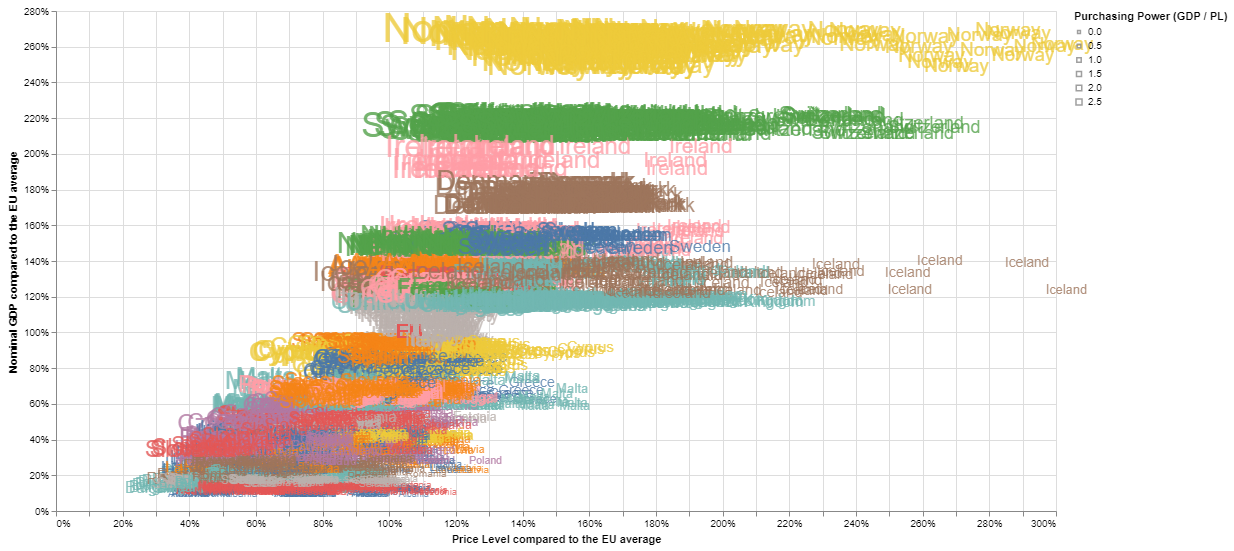

In [77]:
text

In [78]:
text.save("data_based1.json")